<a href="https://colab.research.google.com/github/DuyMinhDo/PriceChangePrediction/blob/main/FPT_Price_Volatility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [119]:
df = pd.read_csv('FPT.csv')
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [120]:
df.dtypes


,0
Ticker,object
Date/Time,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Open Interest,int64


Convert to Data in H1

In [121]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df.set_index('Date/Time', inplace=True)
daily_data = df.resample('H').agg({
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min',
    'Volume': 'sum'
}).reset_index()
daily_data


<ipython-input-121-5cebcb3fbeb6>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_data = df.resample('H').agg({


,Date/Time,Open,Close,High,Low,Volume
0,2018-12-25 09:00:00,30.89,30.66,30.89,30.59,84960
1,2018-12-25 10:00:00,NaN,NaN,NaN,NaN,0
2,2018-12-25 11:00:00,NaN,NaN,NaN,NaN,0
3,2018-12-25 12:00:00,NaN,NaN,NaN,NaN,0
4,2018-12-25 13:00:00,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
17473,2020-12-22 10:00:00,57.50,57.40,57.50,57.30,358010
17474,2020-12-22 11:00:00,57.50,57.40,57.80,57.30,359420
17475,2020-12-22 12:00:00,NaN,NaN,NaN,NaN,0
17476,2020-12-22 13:00:00,57.50,58.00,58.00,57.50,890850


Text(0, 0.5, 'close')

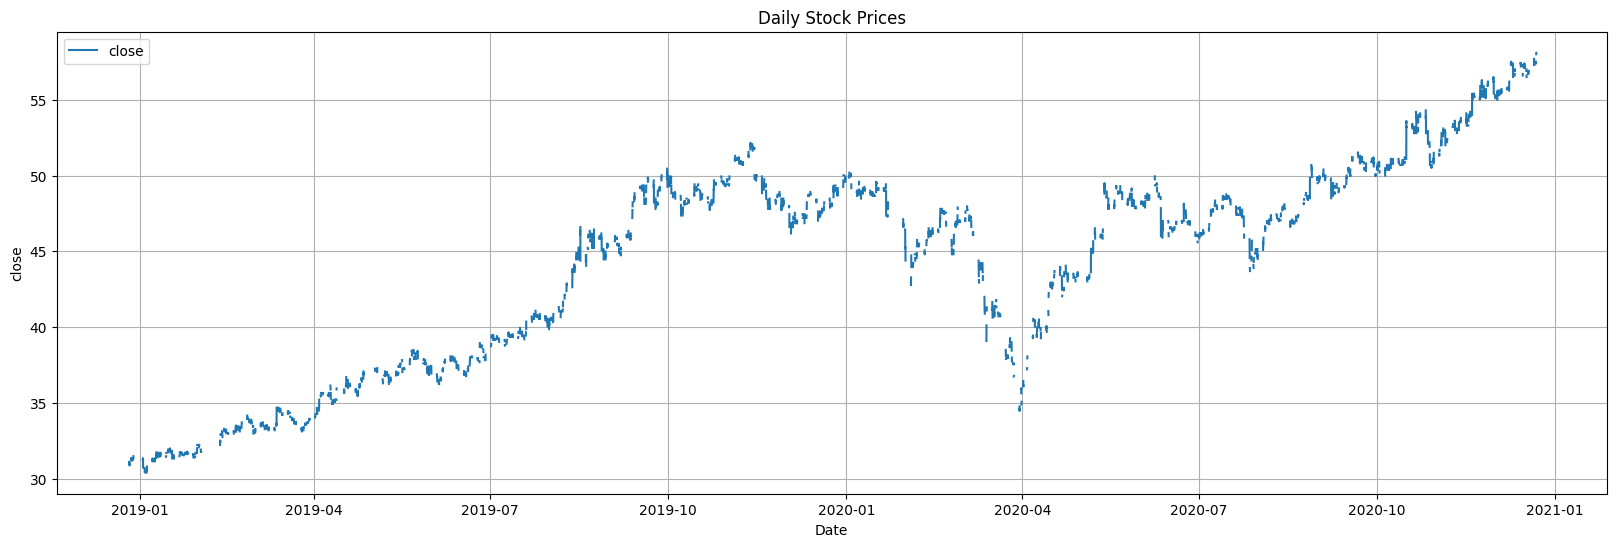

In [122]:
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date/Time'], daily_data['Close'], label='close')
plt.title('Daily Stock Prices')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('close')

In [123]:
daily_data['Price Change']= daily_data['Close'] - daily_data['Close'].shift(+1)
daily_data.dropna(inplace=True)  # Drop the last row with NaN values
daily_data[['Date/Time', 'Close', 'Price Change']]

mean_price_change = daily_data['Price Change'].mean()
print(f'Mean Price Change: {mean_price_change}')


Mean Price Change: -0.0013119143239626147


Create more features


In [124]:
!pip install pandas_ta

import pandas_ta as ta

# Calculate technical indicators using pandas_ta
daily_data['RSI'] = ta.rsi(daily_data['Close'], length=14)
daily_data['SMA_20'] = ta.sma(daily_data['Close'], length=20)
daily_data['SMA_50'] = ta.sma(daily_data['Close'], length=50)
daily_data['EMA_12'] = ta.ema(daily_data['Close'], length=12)
daily_data['EMA_26'] = ta.ema(daily_data['Close'], length=26)
daily_data['MACD'] = daily_data['EMA_12'] - daily_data['EMA_26']
daily_data['Signal_Line'] = ta.ema(daily_data['MACD'], length=9)
#Bollinger
bbands = ta.bbands(daily_data['Close'], length=20, std=2)
daily_data['Bollinger_High'] = bbands['BBU_20_2.0']
daily_data['Bollinger_Low'] = bbands['BBL_20_2.0']
#Stochastic
stoch_data = ta.stoch(daily_data['High'], daily_data['Low'], daily_data['Close'])
daily_data['Stochastic_K'] = stoch_data['STOCHk_14_3_3']
daily_data['Stochastic_D'] = stoch_data['STOCHd_14_3_3']
#ADX
adx_indicator = ta.adx(daily_data['High'], daily_data['Low'], daily_data['Close'], length=14)
daily_data['ADX'] = adx_indicator['ADX_14']
daily_data['CCI'] = ta.cci(daily_data['High'], daily_data['Low'], daily_data['Close'], length=20)
daily_data['ROC'] = ta.roc(daily_data['Close'], length=10)
daily_data['Williams_R'] = ta.willr(daily_data['High'], daily_data['Low'], daily_data['Close'], length=14)
daily_data['ATR'] = ta.atr(daily_data['High'], daily_data['Low'], daily_data['Close'], length=14)
daily_data['OBV'] = ta.obv(daily_data['Close'], daily_data['Volume'])
daily_data['MFI'] = ta.mfi(daily_data['High'], daily_data['Low'], daily_data['Close'], daily_data['Volume'], length=14)
daily_data['Force_Index'] = ta.volume.efi(daily_data['Close'], daily_data['Volume'], length=13)
daily_data['Volume_EMA'] = ta.ema(daily_data['Volume'], length=20)

<ipython-input-124-bc9cd80b2280>:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.46006810e+06 1.13908783e+06 1.80134400e+06 7.90638000e+05
 5.90914800e+06 4.19633870e+06 7.34385867e+05 1.63036500e+06
 4.25892647e+06 1.52388720e+06 2.72616267e+06 3.54651253e+06
 4.13802570e+06 1.55981490e+06 7.54284000e+05 2.27193400e+06
 6.24303540e+06 3.11121200e+05 2.85256213e+06 2.27282573e+06
 1.67470497e+06 2.81321080e+06 1.58905120e+06 2.71707620e+06
 4.01461767e+05 1.47953280e+06 8.12738400e+05 1.86365227e+06
 1.57382997e+06 2.45569180e+06 1.34977540e+06 1.88642790e+06
 7.66436500e+05 2.56934080e+06 2.62498550e+06 2.79353860e+06
 5.77115697e+06 4.94965233e+06 7.28246853e+06 7.55742420e+06
 4.83628133e+06 1.05356748e+07 6.57680040e+06 2.15907807e+06
 4.07319833e+06 7.77021120e+06 1.24808367e+06 3.56468977e+06
 3.31966380e+06 9.98833593e+06 6.32858520e+06 1.60061323e+06
 5.60740180e+06 8.41186710e+06 3.49620840

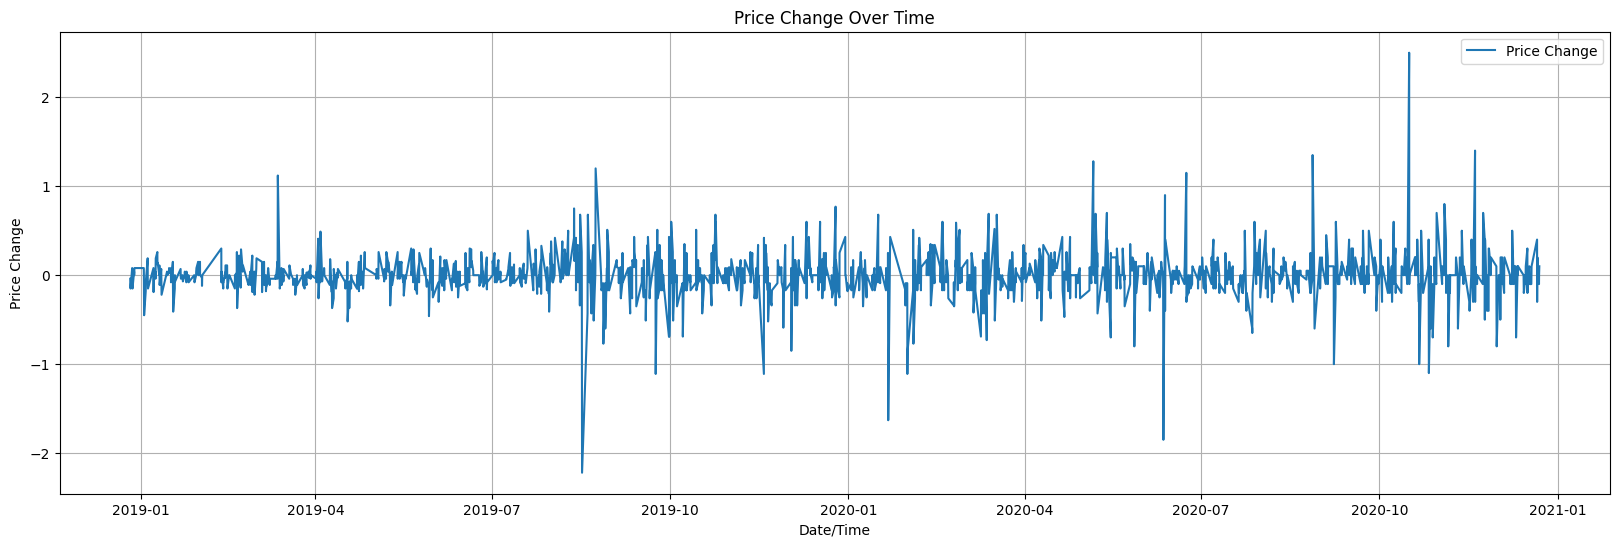

In [125]:
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date/Time'], daily_data['Price Change'], label='Price Change')
plt.xlabel('Date/Time')
plt.ylabel('Price Change')
plt.title('Price Change Over Time')
plt.legend()
plt.grid(True)
plt.show()


MODEL

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [149]:
X = daily_data[['Open', 'High', 'Low', 'Volume', 'Close', 'RSI', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'Bollinger_High', 'Bollinger_Low', 'Stochastic_K', 'Stochastic_D', 'ADX', 'CCI', 'ROC', 'Williams_R', 'ATR', 'OBV', 'MFI', 'Force_Index', 'Volume_EMA']]
y = daily_data['Price Change']

Split (80% for train and 20% for test)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [151]:
from sklearn.impute import SimpleImputer
X_train = SimpleImputer(strategy='mean').fit_transform(X_train)
X_test = SimpleImputer(strategy='mean').fit_transform(X_test)


Random Forest and hyperparameter


In [209]:
# Create Object for RFR
rf = RandomForestRegressor()

#Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [100, 200],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'n_jobs' : [-1]
}

# Create a GridSearchCV Object
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'r2')

#Fit the GridSearchCV object to training Data
grid_search.fit(X_train, y_train)

#Print the best hypeparameters
print(grid_search.best_params_)

best_params = grid_search.best_params_


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

{'max_depth': 200, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1}


Initialize models

In [210]:
rf = RandomForestRegressor(**best_params)

Train the models


In [211]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=200, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1)

Predict by RandomForest and calculates MSE and RMSE for the Random Forest model.

In [212]:
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf_train = mean_squared_error(y_train, rf.predict(X_train), squared = False)
rmse_rf_test = mean_squared_error(y_test, y_pred_rf, squared = False)
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r2_rf}')
print(f'Root Mean Squared Error for train (Random Forest): {rmse_rf_train}')
print(f'Root Mean Squared Error for test (Random Forest): {rmse_rf_test}')

Mean Squared Error (Random Forest): 0.04063350364883225
R-squared (Random Forest): 0.2816703649457464
Root Mean Squared Error for train (Random Forest): 0.11960513245204578
Root Mean Squared Error for test (Random Forest): 0.20157753756019606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


OverFitting or not

In [190]:
if rmse_rf_train < rmse_rf_test:
  print("Potential overfitting detected in Random Forest.\n")
else:
  print("No potential overfitting detected in Random Forest.\n")

Potential overfitting detected in Random Forest.



Plotting

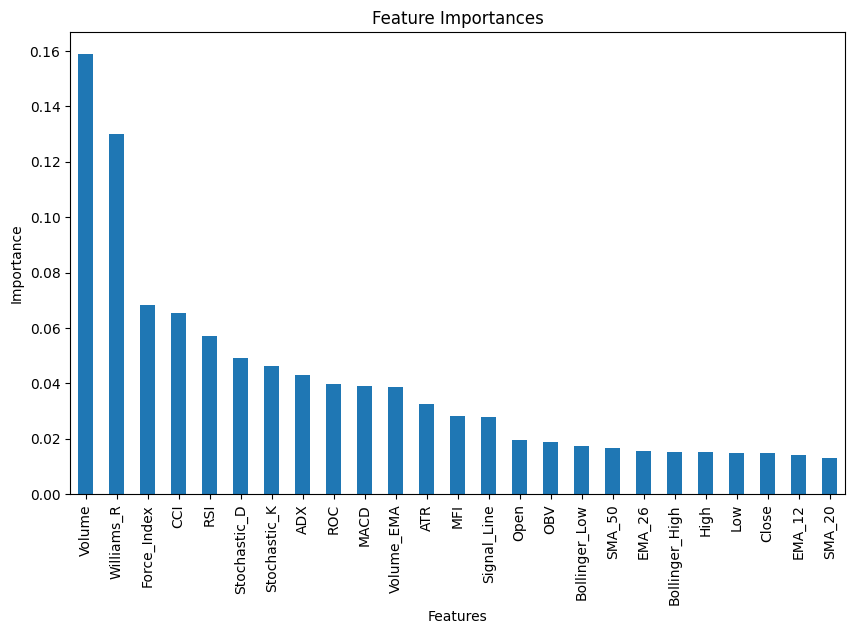

In [215]:
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

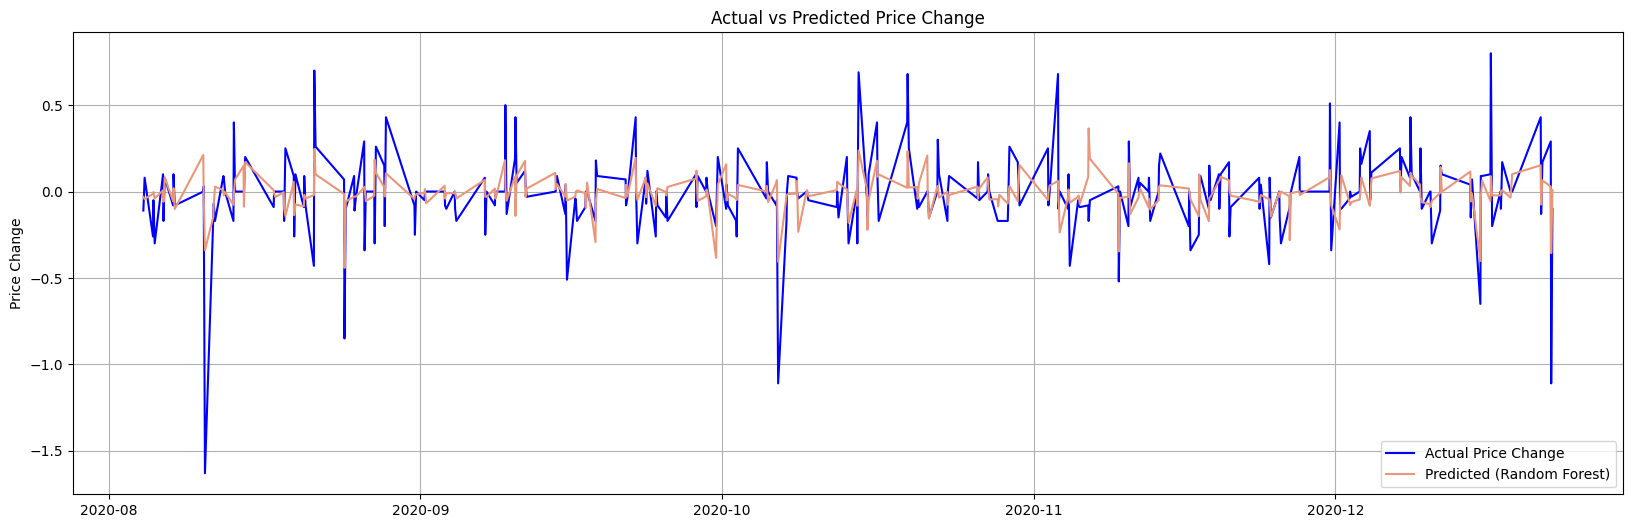

In [191]:
plt.figure(figsize=(20, 6))
test_dates = daily_data['Date/Time'][len(daily_data) - len(y_test):]
plt.plot(test_dates, y_test, label='Actual Price Change', color='blue')
plt.plot(test_dates, y_pred_rf, label='Predicted (Random Forest)', color='darksalmon')
plt.title('Actual vs Predicted Price Change')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression

initialize model

In [136]:
linear_model = LinearRegression()

Traning model

In [137]:
linear_model.fit(X_train, y_train)

LinearRegression()

Predict by Linear Regression and calculate R2, MSE, RMSE

In [138]:
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear_train = mean_squared_error(y_train, linear_model.predict(X_train), squared = False)
rmse_linear_test = mean_squared_error(y_test, y_pred_linear, squared = False)
print(f'Mean Squared Error (Linear Regression): {mse_linear}')
print(f'R-squared (Linear Regression): {r2_linear}')
print(f'Root Mean Squared Error for train (Linear Regression): {rmse_linear_train}')
print(f'Root Mean Squared Error for test (Linear Regression): {rmse_linear_test}')

Mean Squared Error (Linear Regression): 0.0026196204095111095
R-squared (Linear Regression): 0.9616528271205553
Root Mean Squared Error for train (Linear Regression): 0.04325157338080735
Root Mean Squared Error for test (Linear Regression): 0.0511822274770365


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


OverFitting or not

In [139]:
if rmse_linear_train < rmse_linear_test:
  print("Potential overfitting detected in Linear Regression.\n")
else:
  print("No potential overfitting detected in Linear Regression.\n")

Potential overfitting detected in Linear Regression.



Plotting

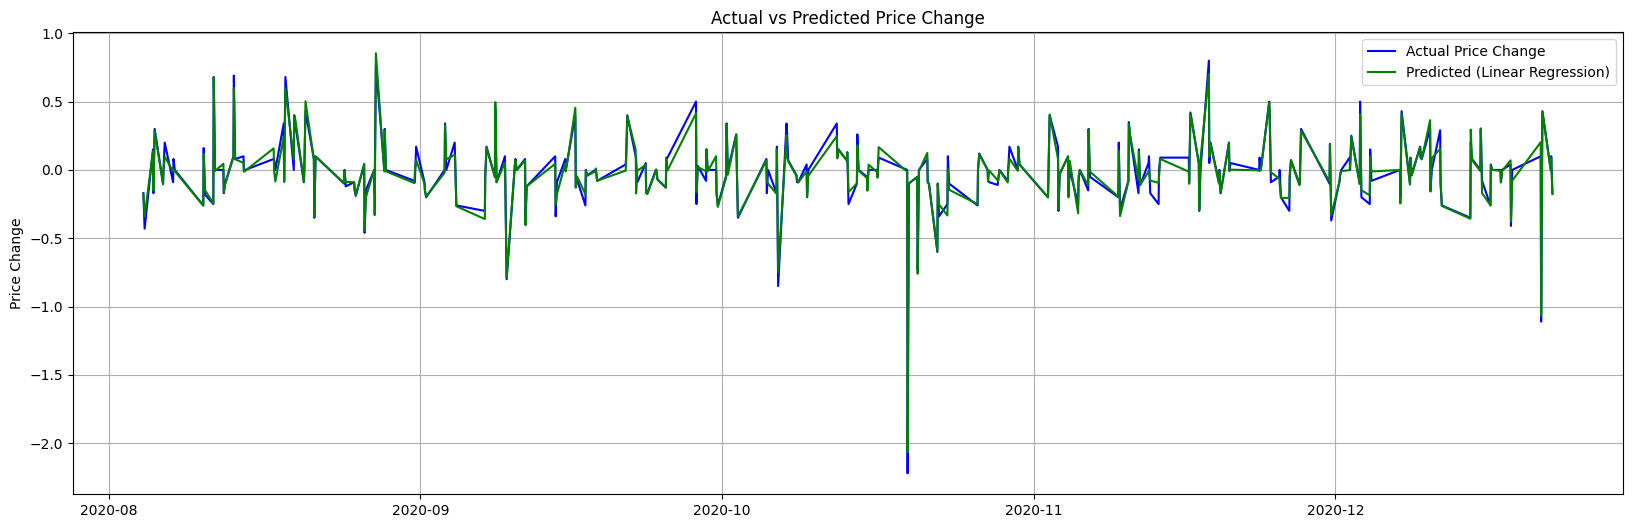

In [140]:
plt.figure(figsize=(20, 6))
test_dates = daily_data['Date/Time'][len(daily_data) - len(y_test):]
plt.plot(test_dates, y_test, label='Actual Price Change', color='blue')
plt.plot(test_dates, y_pred_linear, label='Predicted (Linear Regression)', color='green')
plt.title('Actual vs Predicted Price Change')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.show()

LSTM


In [141]:
from sklearn.preprocessing import MinMaxScaler #use for scaling and normalizing data

#Normalize
scaler = MinMaxScaler() #initilaize object
price_change_scaler = MinMaxScaler()

# Select only numeric features for scaling
numeric_features = daily_data.select_dtypes(include=['number']).columns
daily_data_scaled = scaler.fit_transform(daily_data[numeric_features]) #fit the scaler by calculating min and max value, then transform to 0 1

# Fit the price_change_scaler to the 'Price Change' column
price_change_scaler.fit(daily_data[['Price Change']])

#Split the data into training and testing set
train_size = int(len(daily_data_scaled) * 0.8)
train_data, test_data = daily_data_scaled[:train_size], daily_data_scaled[train_size:]

In [142]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range (len(data) - sequence_length ):
        x.append(data[i:(i+ sequence_length), 0]) # Collect sequence of length
        y.append(data[i + sequence_length, 0]) # Collect the next value as the target
    return np.array(x), np.array(y) #Converts the list of input sequences and target value into a NumPy array.

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


# Reshape to (samples, sequence_length, features) for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [143]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    # Define the input shape using Input layer
    inputs = Input(shape=(X_train.shape[1], 1))

    # First LSTM layer (no need to specify input_shape here)
    x = LSTM(units=units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)

    # Second LSTM layer
    x = LSTM(units=units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)

    # Third LSTM layer
    x = LSTM(units=units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)

    # Dense Layer
    x = Dense(units=units)(x)
    x = Dropout(dropout_rate)(x)

    # Output Layer
    outputs = Dense(units=1)(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Create a KerasRegressor wrapper for the LSTM model
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__units': [50, 100, 200],
    'model__dropout_rate': [0.1, 0.2, 0.5],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Get the best model and its parameters
best_params = grid.best_params_
best_params = {k.replace('model__', ''): v for k, v in best_params.items()}
best_model = create_model(**best_params)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Fit the model with the best parameters
best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Best Hyperparameters: {'dropout_rate': 0.2, 'units': 200}
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.0734 - val_loss: 0.0054
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0018 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Mean Squared Error (LSTM): 0.0004425153377664877
R-squared (LSTM): 0.9632363269758643
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root Mean Squared Error for train (LSTM): 0.020495974025924575
Root Mean Squared Error for test (LSTM): 0.021036048530237036
Potential overfitting detected in LSTM.



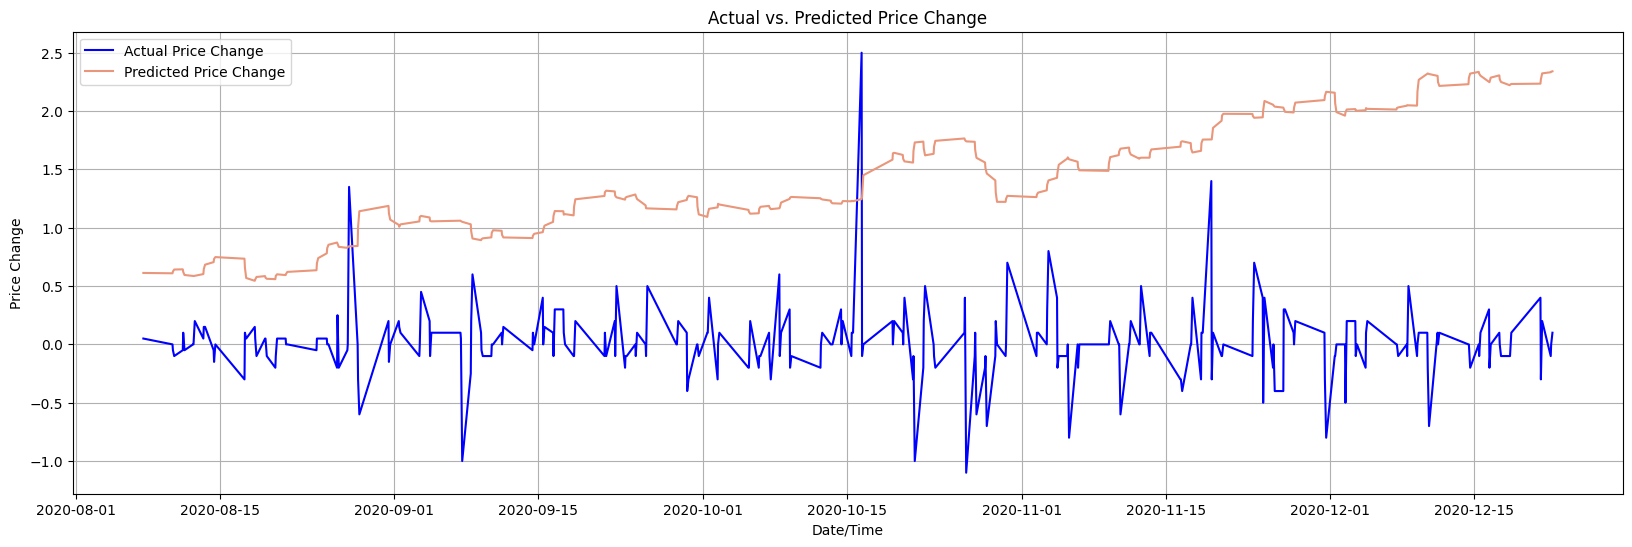

In [146]:
predictions = best_model.predict(X_test)


from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (LSTM): {mse}')

from sklearn.metrics import r2_score

print(f'R-squared (LSTM): {r2_score(y_test, predictions)}')

rmse_lstm_train = mean_squared_error(y_train, best_model.predict(X_train), squared = False)
rmse_lstm_test = mean_squared_error(y_test, predictions, squared = False)
print(f'Root Mean Squared Error for train (LSTM): {rmse_lstm_train}')
print(f'Root Mean Squared Error for test (LSTM): {rmse_lstm_test}')
if rmse_lstm_train < rmse_lstm_test:
  print("Potential overfitting detected in LSTM.\n")
else:
  print("No potential overfitting detected in LSTM.\n")

predictions_original_scale = price_change_scaler.inverse_transform(predictions.reshape(-1, 1))  # Reshape for inverse_transform
predictions_original_scale = predictions_original_scale.flatten()  # Flatten back to 1D

test_dates_adjusted = daily_data['Date/Time'][train_size + sequence_length : train_size + sequence_length + len(predictions)]

plt.figure(figsize=(20, 6))
plt.plot(daily_data['Date/Time'][train_size + sequence_length:], daily_data['Price Change'][train_size + sequence_length:], label='Actual Price Change', color='blue')  # Use original 'Price Change' for actual values
plt.plot(test_dates_adjusted, predictions_original_scale, label='Predicted Price Change', color='darksalmon')  # Use inverse-transformed predictions with adjusted dates
plt.xlabel('Date/Time')
plt.ylabel('Price Change')
plt.title('Actual vs. Predicted Price Change')
plt.legend()
plt.grid(True)
plt.show()
